In [1]:
# lets import xarray and numpy
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load and combine different models and experiments into one dataset

The data arrays do not have consistent coordinates, so we need to set a simple coordinate system. For $(x,y)$ we'll use a grid with spacings of 1 km by 1 km, centered at (0,0). We know that the model output covers a range from -3040 to 3040 km in each direction. For time, we simply use integer values to represent the number of years that have passed (starting at 0 = year 2015).

In [506]:
model_list = ['issm','cism']
exp_list = ['exp05','exp07']
ds_models = []
for model in model_list:
    ds_exps = []
    for exp in exp_list+['ctrl_proj']:
        ds_exp = xr.open_mfdataset("*"+model.upper()+"/"+exp+"/*.nc")
        
        GRID_EXTENT = 3040 # km
        num_tt = len(ds_exp.time)
        grid_resolution_x = 2 * GRID_EXTENT / (len(ds_exp.x) - 1) # km
        grid_resolution_y = 2 * GRID_EXTENT / (len(ds_exp.y) - 1) # km
        x_km, y_km = (ds_exp.x * grid_resolution_x , ds_exp.y * grid_resolution_y) 
        x_km -= grid_extent
        y_km -= grid_extent
        gridspace_area = grid_resolution_x*grid_resolution_y # km^2
        t_year = np.arange(num_tt)

        coords = {"x":x_km , "y":y_km, "time": t_year}
        ## TODO: use WGS84
        try:
            ds_exp = ds_exp.rename({'ny':'y'})
            ds_exp = ds_exp.assign_coords(coords)
            ds_exps.append(ds_exp)
        except:
            ds_exp = ds_exp.assign_coords(coords)
            ds_exps.append(ds_exp)
            continue
        
    ds_model = xr.concat(ds_exps, pd.Index(exp_list+['ctrl'], name='experiment'))
    ds_models.append(ds_model)
    
ism_dataset = xr.concat(ds_models, pd.Index(model_list, name='model'))

We have added two extra dimensions to our dataset: experiment and model. In this demo we look at only two examples of each. 

In [524]:
ism_dataset.model.attrs = {'issm':'JPL1_ISSM_std', 'cism':'NCAR_CISM_std'}
ism_dataset.experiment.attrs = {'exp05':'NorESM1 RCP 8.5', 'exp07':'NorESM1 RCP 2.6', 'ctrl':'Control'}

## Functions for computing ice mass and sea level rise

First we need the total volume of grounded ice. This is done by summing up the product of the ice thickness $h$ with the grid area $\textrm{d}A$ over all grid points $i$, scaled by the fraction of that grid area for which that ice is grounded $F_{\text{grounded}}$: $V_{\text{grounded}} = \sum_i \left( h_{\text{i}} \times \textrm{d}A_i \times F_{\text{grounded},i} \right)$ 

Then, in order to find the volume of water that would be displaced by this ice, we need to scale by the ratios of density:
$V_{\text{water}} = V_{\text{grounded}} \times \frac{\rho_{\text{ice}}}{\rho_{\text{seawater}}}$

Finally, to get the rise in the sea level, $\Delta h$, we use the surface area of the ocean, $A_{\text{ocean}}$:
$\Delta h = \frac{V_{\text{water}}}{A_{\text{ocean}}} \times 10^6 \, \text{mm}$

In [626]:
# Constants
ICE_DENSITY = 0.917 # in Gt / km ^3
WATER_DENSITY = 1.027  # Gt / km ^3
OCEAN_SURFACE_AREA = 361.8 * 10**6  # km²

def sea_level_rise(grounded_ice_mass_gt):

    # Convert grounded ice mass to water equivalent volume (in km³)
    water_volume_km3 = grounded_ice_mass_gt * (ICE_DENSITY / WATER_DENSITY)

    # Calculate the sea level rise in mm
    sea_level_rise_mm = (water_volume_km3 / OCEAN_SURFACE_AREA) * 10**6  # mm

    return sea_level_rise_mm

def get_ice_mass_area(lithk, fraction=None):
    
    thickness =  lithk * 1e-3 # convert to km units
    
    ones_array = xr.DataArray(np.ones_like(thickness), coords=thickness.coords, dims=thickness.dims)
    masked_ones = ones_array.where(~np.isnan(thickness))
    
    # Mask the DataArray to replace NaNs with 0
    masked_data = thickness.where(~np.isnan(thickness), other=0)
    if fraction is not None:
        fraction = fraction.where(~np.isnan(fraction), other=0)
        masked_data *= fraction
        masked_ones *= fraction
    
    # Integrate over the x and y coordinates
    dx = np.gradient(thickness.coords['x']) # in km 
    dy = np.gradient(thickness.coords['y']) # in km 
    
    # Create an area array if the grid spacing varies
    integrated_area = (masked_ones * dx[:, np.newaxis] * dy).sum(dim=['x', 'y'])
    integrated_area = integrated_area.compute()/1e7 # in 1e7 km ^2
    
    volume = (masked_data * dx[:, np.newaxis] * dy).sum(dim=['x', 'y'])
    volume = volume.compute() # in km ^3
    
    ice_mass = volume*ICE_DENSITY/1e7 # convert to in Gt 1e7 units
    
    return ice_mass, integrated_area

### Let's compute the mass of land ice at the beginning of the experiment

In [ ]:
issm_ctrl = ism_dataset.sel(model='issm',experiment='ctrl')

total_ice = get_ice_mass_area(issm_ctrl.lithk.isel(time=0))
print(total_ice[0].item()*1e7,' Gt of total ice at beginning of experiment')

floating_ice = get_ice_mass_area(issm_ctrl.lithk.isel(time=0),fraction=issm_ctrl.sftflf.isel(time=0))
print(floating_ice[0].item()*1e7,' Gt of floating ice at beginning of experiment')

grounded_ice = get_ice_mass_area(issm_ctrl.lithk.isel(time=0),fraction=issm_ctrl.sftgrf.isel(time=0))
print(grounded_ice[0].item()*1e7,' Gt of grounded ice at beginning of experiment')

# NOTE: 
# lithk = orog - base (ice thickness = surface altitude - base altitude)
# ice thickness = floating ice + grounded ice

## Compute Sea level contribution and combine with existing dataset

We want to compare the results of each experiment with the 'control', so we need to find the relative sea level rise.

In [ ]:
num_model = len(model_list)
num_exp = len(exp_list)
num_tt = len(ism_model.coords['time'])

mmSLE = xr.DataArray(
    np.zeros((num_tt, num_exp, num_model)),
    dims=['time', 'experiment', 'model'],
    coords={
        'time': ism_model.coords['time'],
        'experiment': exp_list,
        'model': model_list
    },
    name='mmsle'  # Name of the new variable
)

for i in range(num_model):
    model = model_list[i]
    ism_model = ism_dataset.sel(model=model)
    ice_mass_ctrl = get_ice_mass_area(ism_model.sel(experiment='ctrl').lithk,fraction=ism_model.sel(experiment='ctrl').sftgrf.isel(time=0))[0]
    for j in range(num_exp):
        exp = exp_list[j]
        ice_mass_exp = get_ice_mass_area(ism_model.sel(experiment=exp).lithk,fraction=ism_model.sel(experiment=exp).sftgrf.isel(time=0))[0]
        ice_above_floatation = ice_mass_exp.values - ice_mass_ctrl.values
        sle = sea_level_rise(-ice_above_floatation*1e7)
        mmSLE.sel(experiment=exp,model=model)[:] = sle
        
ism_dataset['mmsle'] = mmSLE

## Save the dataset as an nc file

In [532]:
#filename = './ISMIP6_output.nc'
#print ('saving to ', filename)
#ism_dataset.to_netcdf(path=filename)

## Reproducing Figure 4

Figure 4 shows the evolution of ice volume above floatation (in mm SLE) over 2015-2100 from the NorESM1-M RCP 8.5 scenario (exp05) relative to ctrl_proj.

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

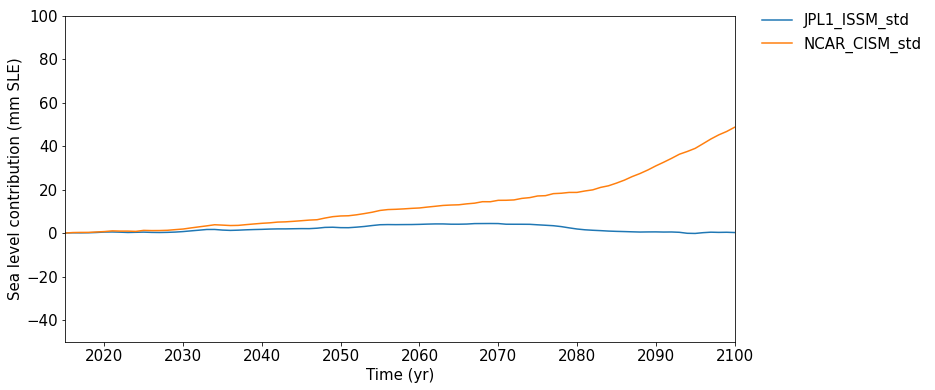

In [523]:
# Fig 4 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
plt.figure(figsize=(12,6))

years = 2015 + np.arange(num_tt)

for model in model_list:
    plt.plot(years, ism_dataset.sel(model=model).sel(experiment='exp05').mmsle, label=ism_dataset.model.attrs[model])

plt.legend(fontsize=15, bbox_to_anchor=(1.3, 1.05), frameon=False)
plt.ylabel(r'Sea level contribution (mm SLE)', fontsize=15)
plt.xlabel('Time (yr)', fontsize=15)
plt.ylim(-50,100)
plt.xlim(2015, 2100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Reproducing Figure 6

Figure 6 Mean (left) and standard deviation (right) of simulated thickness change (in m) between 2015 and 2100 under medium forcing from the NorESM1-M RCP 8.5 scenario (exp05) relative to ctrl_proj. 

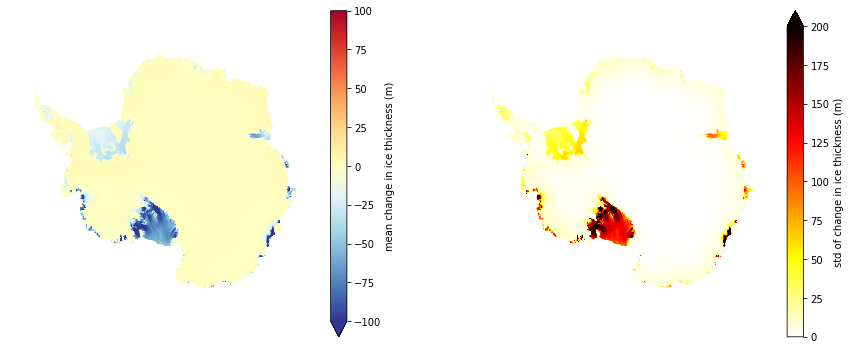

In [622]:
# Fig 6 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
fig, axs = plt.subplots(ncols=2, figsize=(15,6))

seconds_per_year = 60*60*24*365

## why multiply by number of years rather than the number of seconds??

# find the mean of tendency of land ice thickness in m/s
frac_land_ice = ism_dataset.sftgrf.sel(model='issm',experiment='exp05',time=0)
mean_thickness = num_tt*ism_dataset.sel(experiment='exp05').dlithkdt.mean(dim=['model','time'], skipna=True)
mean_thickness += frac_land_ice.where(np.isnan(frac_land_ice), other=0)

std_thickness = num_tt*ism_dataset.sel(experiment='exp05').dlithkdt.std(dim=['model','time'], skipna=True)
std_thickness += frac_land_ice.where(np.isnan(frac_land_ice), other=0)

im1 = mean_thickness.plot(ax=axs[0], cmap='RdYlBu_r', vmin=-100, vmax=100)
im2 = std_thickness.plot(ax=axs[1], cmap='hot_r', vmin=0, vmax=200)
axs[0].set_title('')
axs[0].axis('off')
im1.colorbar.set_label('mean change in ice thickness (m)')

axs[1].set_title('')
axs[1].axis('off')
im2.colorbar.set_label('std of change in ice thickness (m)')

## Reproducing Figure 9

Figure 9 shows the impact of RCP scenario on projected evolution of ice volume above floatation for the NorESM1-M models. Red and blue curves show mean evolution for RCP 8.5 and RCP 2.6, respectively, and the shaded background shows the standard deviation. (only 2 models are used here)

(array([-40., -20.,   0.,  20.,  40.,  60.,  80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

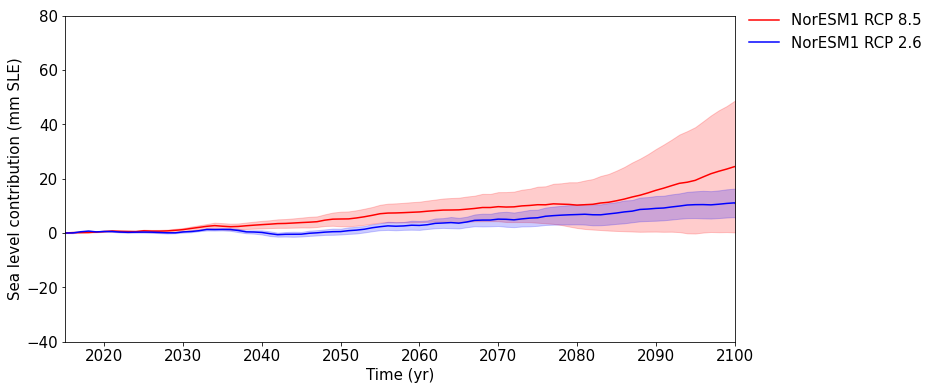

In [538]:
# Fig 9 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
plt.figure(figsize=(12,6))

colors = {'exp05':'red','exp07':'blue'}

for exp in exp_list:
    mean_SLE = ism_dataset.sel(experiment=exp).mmsle.mean(dim='model', skipna=True)
    std_SLE = ism_dataset.sel(experiment=exp).mmsle.std(dim='model', skipna=True)

    plt.plot(years, mean_SLE, color=colors[exp], label=ism_dataset.experiment.attrs[exp])
    plt.fill_between(years, mean_SLE+std_SLE, mean_SLE-std_SLE, color=colors[exp], alpha=0.2)
    
plt.legend(fontsize=15, bbox_to_anchor=(1.3, 1.05), frameon=False)
plt.ylabel(r'Sea level contribution (mm SLE)', fontsize=15)
plt.xlabel('Time (yr)', fontsize=15)
plt.ylim(-40,80)
plt.xlim(2015, 2100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)